In [1]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import numbers
import decimal
import sys
import os
import datetime

In [2]:
# download data

os.system("wget -N https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")

os.system("wget -N https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")

os.system("wget -N https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")


0

In [3]:
confirmed = pd.read_csv('time_series_covid19_confirmed_global.csv')
deaths = pd.read_csv('time_series_covid19_deaths_global.csv')
recovered = pd.read_csv('time_series_covid19_recovered_global.csv')

print(confirmed.head())

colnames = confirmed.columns.tolist()
print(colnames)

  Province/State Country/Region      Lat     Long  1/22/20  1/23/20  1/24/20  \
0            NaN    Afghanistan  33.0000  65.0000        0        0        0   
1            NaN        Albania  41.1533  20.1683        0        0        0   
2            NaN        Algeria  28.0339   1.6596        0        0        0   
3            NaN        Andorra  42.5063   1.5218        0        0        0   
4            NaN         Angola -11.2027  17.8739        0        0        0   

   1/25/20  1/26/20  1/27/20  ...  6/6/20  6/7/20  6/8/20  6/9/20  6/10/20  \
0        0        0        0  ...   19551   20342   20917   21459    22142   
1        0        0        0  ...    1232    1246    1263    1299     1341   
2        0        0        0  ...   10050   10154   10265   10382    10484   
3        0        0        0  ...     852     852     852     852      852   
4        0        0        0  ...      88      91      92      96      113   

   6/11/20  6/12/20  6/13/20  6/14/20  6/15/20  
0

In [4]:
start = datetime.datetime.strptime(colnames[4], "%m/%d/%y")
end = datetime.datetime.strptime(colnames[-1], "%m/%d/%y")
date_generated = [start + datetime.timedelta(days=x) for x in range(0, (end-start).days+1)]

print(confirmed.shape)
print(date_generated)

(266, 150)
[datetime.datetime(2020, 1, 22, 0, 0), datetime.datetime(2020, 1, 23, 0, 0), datetime.datetime(2020, 1, 24, 0, 0), datetime.datetime(2020, 1, 25, 0, 0), datetime.datetime(2020, 1, 26, 0, 0), datetime.datetime(2020, 1, 27, 0, 0), datetime.datetime(2020, 1, 28, 0, 0), datetime.datetime(2020, 1, 29, 0, 0), datetime.datetime(2020, 1, 30, 0, 0), datetime.datetime(2020, 1, 31, 0, 0), datetime.datetime(2020, 2, 1, 0, 0), datetime.datetime(2020, 2, 2, 0, 0), datetime.datetime(2020, 2, 3, 0, 0), datetime.datetime(2020, 2, 4, 0, 0), datetime.datetime(2020, 2, 5, 0, 0), datetime.datetime(2020, 2, 6, 0, 0), datetime.datetime(2020, 2, 7, 0, 0), datetime.datetime(2020, 2, 8, 0, 0), datetime.datetime(2020, 2, 9, 0, 0), datetime.datetime(2020, 2, 10, 0, 0), datetime.datetime(2020, 2, 11, 0, 0), datetime.datetime(2020, 2, 12, 0, 0), datetime.datetime(2020, 2, 13, 0, 0), datetime.datetime(2020, 2, 14, 0, 0), datetime.datetime(2020, 2, 15, 0, 0), datetime.datetime(2020, 2, 16, 0, 0), datetime.

In [5]:
def pred_function(series__, k__ = 1, delta_AR__ = 1, alpha__ = 0.5):  
    # Newton-Leibniz baseline -- local prediction by derivative
    # In 1665, following an outbreak of the bubonic plague in England, 
    # Cambridge University closed its doors, forcing Newton to return home and 
    # develop Differential calculus.
    # Leibniz's most prominent accomplishment was conceiving the ideas of differential and integral calculus, 
    # independently of Isaac Newton's contemporaneous developments.
    # Local prediction by derivative
    # Discrete backward derivative delta(x) = f(x) - f(x-1)
    # f(x+1)= delta(x)+f(x) + epsilon
    # k__ : prediction interval
    # delta_AR__ : if Exponential Weighted Moving Average for Derivative is used with alpha__ param
    
    delta_series = [series__[-i]-series__[-i-1] for i in range(1,delta_AR__+1)]
    
    if (delta_AR__== 1) or (delta_AR__>len(series__)+1):
        delta = series__[-1] - series__[-2]
    else:
        weights = [alpha__*(1-alpha__)**i for i,val in enumerate(delta_series)]
        delta = sum([val*alpha__*((1-alpha__)**i)/(sum(weights)) for i,val in enumerate(delta_series)])
  
    pred = k__*delta + series__[-1]
    return pred

In [6]:
# Error estimation 
# O(n) = f(n) + epsilon(n)
# epsilon(n) ~ distribution I.I.D that has VAR sigma^2

#\hat(f(n)) = O(n-1) + k*delta(n)
# STD(\hat(f(n)))= ?
#\hat(f(n)) = O(n-1) + k*O(n-1) - k*O(n-2) = (1+k)*(f(n-1)+epsilon(n-1)) - k*(f(n-2) + epsilon(n-2))

#--------------------------
#for k=1
#VAR[\hat(f(n))] = VAR[2*f(n-1)+2*epsilon(n-1)] + VAR[- f(n-2)] + VAR[- epsilon(n-2)] + \sum COV(,)
#                    VAR[f(n-1)]=0= VAR[- f(n-2)]
#                   = 2^2* simga^2 + sigma^2 = 5* sigma^2
#STD(\hat(f(n))) = \sqrt(5)*sigma
#VAR[O(n)-\hat(f(n))] = sigma^2+ VAR(\hat(f(n)) = 6*sigma^2'

#--------------------------
#for arbitrary k
#VAR[\hat(f(n))] = (1+k)^2*VAR[f(n-1)+epsilon(n-1)] + k^2*VAR[f(n-2) + epsilon(n-2)] + \sum COV(,)
#VAR[f(n-2)]=VAR[f(n-1)]=0, i.i.d. noise \sum COV(,)=0

#VAR[\hat(f(n))] = (1+k)^2*VAR[epsilon(n-1)] + k^2*VAR[epsilon(n-2)]= 
#                = (1+k)^2*sigma^2 + k^2*sigma^2= (1+2k+2*k^2)*sigma^2

#VAR[O(n)-\hat(f(n))]=  sigma^2+ VAR(\hat(f(n)) = (2+2k+2*k^2)*sigma^2 = 2(1+k+k^2)*sigma^2
#-------------------

#estimate sigma, by using k = 1 .... and historical data STD[O(n)-\hat(f(n))|k=1, n=1^window_days]
# sigma = sqrt(5)/sqrt(6) * STD[O(n)-\hat(f(n))|k=1]
# then STD[\hat(f(n))] = sqrt((1+2k+2*k^2))*sqrt(5)/sqrt(6) * STD[O(n)-\hat(f(n))|k=1, n=1^window_days]


def pred_function_confidence(series__, k__ = 1, window_days__ = 31, delta_AR__ = 1, alpha__ = 0.5):
    # f(x+1)= AR(delta(x))+f(x) + epsilon(x)
    # epsilon(x) is observation i.i.d. noise 
    # k__ : prediction interval
    # window_days__ : how many days ar used to estimate sigma
    # delta_AR__ : if Exponential Weighted Moving Average for Derivative is used with alpha__ param
    
    pred_mean = pred_function(series__,k__, delta_AR__, alpha__)
    
    if (window_days__ + k__ +1 > len(series__)):
        max_offset = len(series__) - k__ - 1
    else:
        max_offset = window_days__
        
    k_tmp = 1 #for estimating error different horizion is used.
    errors_k1 = [series__[-i]-pred_function(series__[0:-i-k_tmp+1], k_tmp, delta_AR__, alpha__) for i in range(1,max_offset+1)] 
    
    sigma = statistics.stdev(errors_k1)*math.sqrt(5)/math.sqrt(6)
    sigma_k =  math.sqrt((1+2*k__+2*k__**2))*sigma
    #print(statistics.stdev(errors_k1), sigma, sigma_k)
     
    # assumption is that the function is monotone increasing 
    conf_factor = 1
    neg_offset = 0
    if (pred_mean-conf_factor*sigma_k < series__[-1]):
        if ( pred_mean < series__[-1] ):
            neg_offset = 0
        else:
            neg_offset = pred_mean-series__[-1]
        return (pred_mean, conf_factor*sigma_k , neg_offset)
    else:
        return (pred_mean, conf_factor*sigma_k , conf_factor*sigma_k)
    


9
1.802674620453555
3.674234614174767


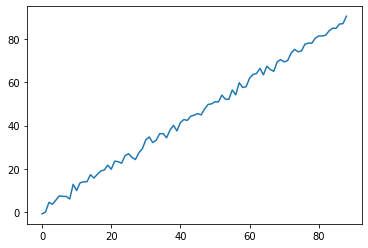

In [7]:
#additive noise -- toy model
window_days = 10
sigma = 1.5
series = [x +np.random.normal(0, sigma) for x in range(1,30*3)]

plt.plot(series)

errors = [series[-i]-pred_function(series[0:-i]) for i in range(1,window_days)] 
print(len(errors))


import statistics 
print(statistics.stdev(errors))
print(math.sqrt(6)*sigma)
#print(math.sqrt(6))

10
(2, 78)


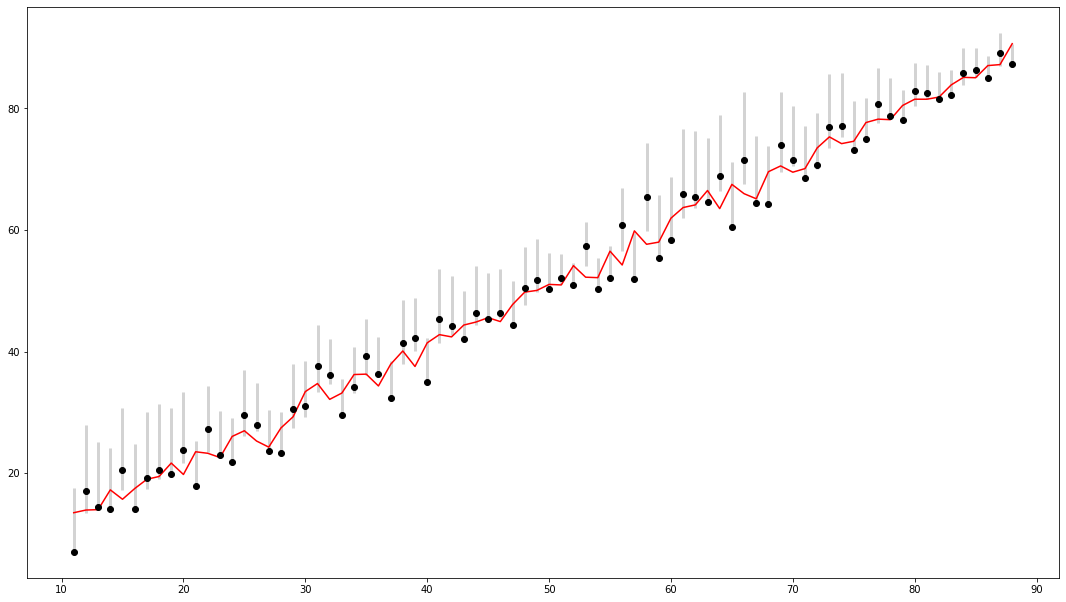

In [8]:
delta_AR = 1
k = 1
print(window_days)
mean_confidence = [ pred_function_confidence( series[0:i], k , window_days, delta_AR ) for i in range(window_days+1,len(series))] 
#print(mean_confidence)


y_mean = [x[0] for x in mean_confidence]
y_error_up = [x[1] for x in mean_confidence]
y_error_down = [ x[2] for x in mean_confidence]
y_error = np.array([y_error_down,y_error_up])
print(y_error.shape)
#y_error = [x[1] for x in mean_confidence]
#print(mean_confidence)


x = [x for x in range(window_days+1,len(series))]
f = [ series[i] for i in range(window_days+1,len(series))] 

plt.errorbar(x, y_mean, y_error,fmt='o', color='black',
             ecolor='lightgray', elinewidth=3, capsize=0)
plt.plot(x,f, 'r')

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)


In [9]:
def write_prediction(file_str__, confirmed__, deaths__, recovered__, num_day_pred__ = 2, \
                     start_date_idx__ = 4, last_date_idx__ = -1, verbose = 0, \
                     countries_select__ = "ALL", data_prediction_list = None,\
                     delta_AR__ = 1, window_days__ = 31):

    if data_prediction_list is None:
        data_prediction_list = []
       
    if (verbose):
        print("window for sigma", window_days__)
    
    colnames = confirmed__.columns.tolist()
    if (last_date_idx__ == -1):
        last_date_idx__ = len(colnames)
        if (verbose):
            print("last_date_idx__", last_date_idx__)
    
    print(start_date_idx__, last_date_idx__)
    f = open(file_str__,"w+")
    f.write("Province/State,Country,Target/Date,N,low95N,high95N,R,low95R,high95R,D,low95D,high95D,T,low95T,high95T,M,low95M,high95M,C,low95C,high95C\n")
    province_null_idx = confirmed__['Province/State'].isnull()
    for idx in range(0,confirmed__.shape[0]):
        try:
            if (province_null_idx[idx] == True):
                loc1_str = ","
            else:
                loc1 = confirmed__['Province/State'].iloc[idx]
                loc1_str = str(loc1).replace(',', ' ') + ","


            loc2 = confirmed__['Country/Region'].iloc[idx]
            loc2_str = str(loc2).replace(',', ' ') + ","
            if (verbose):
                print(loc2_str)
                
            if (countries_select__== "ALL") or (str(loc2) in countries_select__):
                if (province_null_idx[idx] == True):
                    try:
                        tmp_array = confirmed__.iloc[idx][colnames[start_date_idx__:last_date_idx__]].to_numpy()
                        next_confirmed = pred_function( tmp_array, num_day_pred__, delta_AR__ = delta_AR__)
                        if (verbose):
                            print(next_confirmed)

                        conf_interval = pred_function_confidence(tmp_array, k__ = num_day_pred__, delta_AR__ = delta_AR__, window_days__ = window_days__)
                        n_str = str(int(round(next_confirmed)))+","+ \
                            str(int(round(next_confirmed+conf_interval[1])))+"," +\
                            str(int(round(next_confirmed-conf_interval[2])))+ ","
                        
                        confirmed_next_tupple = (next_confirmed, conf_interval[1], conf_interval[2])
                        assert next_confirmed == conf_interval[0]
                    except:
                        if (verbose):
                            print("Error in confirmed case block")
                        next_confirmed = float("NaN")
                        confirmed_next_tupple = (float("NaN"),float("NaN"),float("NaN"))
                        n_str = ",,,"

                    try:
                        tmp_array = deaths__.iloc[idx][colnames[start_date_idx__:last_date_idx__]].to_numpy()
                        next_deaths = pred_function(tmp_array, k__ = num_day_pred__, delta_AR__ = delta_AR__)
                        conf_interval = pred_function_confidence(tmp_array, k__ = num_day_pred__, delta_AR__ = delta_AR__, window_days__ = window_days__)
                        d_str = str(int(round(next_deaths))) + "," + \
                            str(int(round(next_deaths+conf_interval[1])))+"," + \
                            str(int(round(next_deaths-conf_interval[2])))+ ","
                    except:
                        if (verbose):
                            print("Error in death case block")
                        next_deaths = float("NaN")
                        d_str = ",,,"

                    try:
                        tmp_array = recovered__.iloc[idx][colnames[start_date_idx__:last_date_idx__]].to_numpy()
                        next_recovered = pred_function(tmp_array, k__ = num_day_pred__, delta_AR__ = delta_AR__)
                        conf_interval = pred_function_confidence(tmp_array, k__ = num_day_pred__, delta_AR__ = delta_AR__, window_days__ = window_days__)
                        r_str = str(next_recovered)+"," + \
                            str(next_recovered+conf_interval[1])+"," +\
                            str(next_recovered-conf_interval[2])+ ","
                    except:
                        if (verbose):
                            print("Error in recovered case block")
                        next_recovered = float("NaN")
                        r_str = ",,,"

                    if (next_confirmed > 0):
                        if (next_deaths>0):
                            next_mortality = next_deaths / next_confirmed 
                            m_str = str(next_mortality)+",,,"
                        else:
                            m_str = "0,,,"
                    else:
                        next_mortality = float("NaN")
                        m_str = ",,,"

                    next_pred_date_str = next_pred_date.strftime("%Y-%m-%d")+","
                    t_str = ",,,"
                    c_str = ",,\n"

                    data_prediction_list.append((next_pred_date, loc1_str, loc2_str, confirmed_next_tupple))
                    if (verbose):
                        print( (next_pred_date_str, loc1_str, loc2_str, confirmed_next_tupple) )
                    try:
                        f.write(loc1_str+loc2_str+next_pred_date_str+n_str+r_str+d_str+t_str+m_str+c_str)
                    except:
                        print("CAN NOT WRITE to file\n")
        except:
            print("Unexpected error:", sys.exc_info()[0])
    if (verbose):
        print("Closing prediction file\n")
    f.close()
    return data_prediction_list

In [10]:
int(round(45.99))

46

In [12]:
#new day prediction
num_day_pred = 7
delta_AR = 5
window_days = 10
last_date = date_generated[-1]

last_date_str = last_date.strftime("%Y-%m-%d")
next_pred_date = last_date+datetime.timedelta(days=num_day_pred)
file_str = str(num_day_pred)+"day_prediction_" + last_date_str + ".csv"
print(file_str)

print(confirmed.shape[0])

write_prediction(file_str, confirmed, deaths, recovered, num_day_pred, verbose = 1, delta_AR__ = delta_AR, window_days__ = window_days)

7day_prediction_2020-06-15.csv
266
window for sigma 10
last_date_idx__ 150
4 150
Afghanistan,
30443.25806451613
('2020-06-22,', ',', 'Afghanistan,', (30443.25806451613, 1305.9991823099733, 1305.9991823099733))
Albania,
2009.5483870967741
('2020-06-22,', ',', 'Albania,', (2009.5483870967741, 94.47648766435815, 94.47648766435815))
Algeria,
11806.645161290322
('2020-06-22,', ',', 'Algeria,', (11806.645161290322, 63.71382168212908, 63.71382168212908))
Andorra,
853.4516129032259
('2020-06-22,', ',', 'Andorra,', (853.4516129032259, 20.835530465712683, 0.45161290322585046))
Angola,
166.61290322580646
('2020-06-22,', ',', 'Angola,', (166.61290322580646, 58.25762698777634, 24.612903225806463))
Antigua and Barbuda,
26.0
('2020-06-22,', ',', 'Antigua and Barbuda,', (26.0, 0.0, 0.0))
Argentina,
41789.25806451613
('2020-06-22,', ',', 'Argentina,', (41789.25806451613, 1804.0658084041452, 1804.0658084041452))
Armenia,
20753.225806451614
('2020-06-22,', ',', 'Armenia,', (20753.225806451614, 2089.38971

('2020-06-22,', ',', 'Pakistan,', (194072.58064516127, 35380.3647489284, 35380.3647489284))
Panama,
25097.0
('2020-06-22,', ',', 'Panama,', (25097.0, 4174.313326122382, 3675.0))
Papua New Guinea,
8.0
('2020-06-22,', ',', 'Papua New Guinea,', (8.0, 0.0, 0.0))
Paraguay,
1395.3548387096773
('2020-06-22,', ',', 'Paraguay,', (1395.3548387096773, 185.34201195710537, 99.35483870967732))
Peru,
267721.2580645161
('2020-06-22,', ',', 'Peru,', (267721.2580645161, 28771.68656255987, 28771.68656255987))
Philippines,
30085.064516129034
('2020-06-22,', ',', 'Philippines,', (30085.064516129034, 1363.3288956266535, 1363.3288956266535))
Poland,
32544.41935483871
('2020-06-22,', ',', 'Poland,', (32544.41935483871, 1235.2463333078013, 1235.2463333078013))
Portugal,
39143.67741935484
('2020-06-22,', ',', 'Portugal,', (39143.67741935484, 841.4949545635423, 841.4949545635423))
Qatar,
90290.7741935484
('2020-06-22,', ',', 'Qatar,', (90290.7741935484, 2294.8579315846787, 2294.8579315846787))
Romania,
23744.967

[(datetime.datetime(2020, 6, 22, 0, 0),
  ',',
  'Afghanistan,',
  (30443.25806451613, 1305.9991823099733, 1305.9991823099733)),
 (datetime.datetime(2020, 6, 22, 0, 0),
  ',',
  'Albania,',
  (2009.5483870967741, 94.47648766435815, 94.47648766435815)),
 (datetime.datetime(2020, 6, 22, 0, 0),
  ',',
  'Algeria,',
  (11806.645161290322, 63.71382168212908, 63.71382168212908)),
 (datetime.datetime(2020, 6, 22, 0, 0),
  ',',
  'Andorra,',
  (853.4516129032259, 20.835530465712683, 0.45161290322585046)),
 (datetime.datetime(2020, 6, 22, 0, 0),
  ',',
  'Angola,',
  (166.61290322580646, 58.25762698777634, 24.612903225806463)),
 (datetime.datetime(2020, 6, 22, 0, 0),
  ',',
  'Antigua and Barbuda,',
  (26.0, 0.0, 0.0)),
 (datetime.datetime(2020, 6, 22, 0, 0),
  ',',
  'Argentina,',
  (41789.25806451613, 1804.0658084041452, 1804.0658084041452)),
 (datetime.datetime(2020, 6, 22, 0, 0),
  ',',
  'Armenia,',
  (20753.225806451614, 2089.389718222069, 2089.389718222069)),
 (datetime.datetime(2020, 6,

In [16]:
#historial predictions -- start march 04
#subset of countries

countries_select = ['Switzerland', 'Italy', 'Germany', 'US', 'France', 'Spain', 'Netherlands', 'Poland', 'Portugal', 'United Kingdom', 'Croatia', 'Czechia', 'Austria', 'Belgium', 'Luxembourg']
idx_start = 44
num_day_pred = 7
delta_AR = 1
window_days = 30
assert datetime.datetime.strptime(colnames[idx_start-1], "%m/%d/%y") == datetime.datetime(2020, 3, 1, 0, 0)

colnames = confirmed.columns.tolist()
tmp_idx = len(colnames)
while tmp_idx >= idx_start:
    
    last_date = datetime.datetime.strptime(colnames[tmp_idx-1], "%m/%d/%y")
    last_date_str = last_date.strftime("%Y-%m-%d")
    print(last_date_str, tmp_idx)
    next_pred_date = last_date+datetime.timedelta(days=num_day_pred)
    file_str = "newton-leibniz_baseline_predictions_confidence/subset/"+\
        str(num_day_pred)+"day_prediction_" + last_date_str + ".csv"
    print(file_str)
    tmp_res = write_prediction(file_str, confirmed, deaths, recovered, num_day_pred, last_date_idx__ = tmp_idx, \
                     countries_select__ = countries_select, verbose = 0)
    #print(tmp_res)
    
    tmp_idx -=1

2020-06-15 150
newton-leibniz_baseline_predictions_confidence/subset/7day_prediction_2020-06-15.csv
4 150
2020-06-14 149
newton-leibniz_baseline_predictions_confidence/subset/7day_prediction_2020-06-14.csv
4 149
2020-06-13 148
newton-leibniz_baseline_predictions_confidence/subset/7day_prediction_2020-06-13.csv
4 148
2020-06-12 147
newton-leibniz_baseline_predictions_confidence/subset/7day_prediction_2020-06-12.csv
4 147
2020-06-11 146
newton-leibniz_baseline_predictions_confidence/subset/7day_prediction_2020-06-11.csv
4 146
2020-06-10 145
newton-leibniz_baseline_predictions_confidence/subset/7day_prediction_2020-06-10.csv
4 145
2020-06-09 144
newton-leibniz_baseline_predictions_confidence/subset/7day_prediction_2020-06-09.csv
4 144
2020-06-08 143
newton-leibniz_baseline_predictions_confidence/subset/7day_prediction_2020-06-08.csv
4 143
2020-06-07 142
newton-leibniz_baseline_predictions_confidence/subset/7day_prediction_2020-06-07.csv
4 142
2020-06-06 141
newton-leibniz_baseline_predict

2020-03-29 72
newton-leibniz_baseline_predictions_confidence/subset/7day_prediction_2020-03-29.csv
4 72
2020-03-28 71
newton-leibniz_baseline_predictions_confidence/subset/7day_prediction_2020-03-28.csv
4 71
2020-03-27 70
newton-leibniz_baseline_predictions_confidence/subset/7day_prediction_2020-03-27.csv
4 70
2020-03-26 69
newton-leibniz_baseline_predictions_confidence/subset/7day_prediction_2020-03-26.csv
4 69
2020-03-25 68
newton-leibniz_baseline_predictions_confidence/subset/7day_prediction_2020-03-25.csv
4 68
2020-03-24 67
newton-leibniz_baseline_predictions_confidence/subset/7day_prediction_2020-03-24.csv
4 67
2020-03-23 66
newton-leibniz_baseline_predictions_confidence/subset/7day_prediction_2020-03-23.csv
4 66
2020-03-22 65
newton-leibniz_baseline_predictions_confidence/subset/7day_prediction_2020-03-22.csv
4 65
2020-03-21 64
newton-leibniz_baseline_predictions_confidence/subset/7day_prediction_2020-03-21.csv
4 64
2020-03-20 63
newton-leibniz_baseline_predictions_confidence/sub

In [18]:
#combine files ...
run_command = "python files_combine_leibniz.py"
run_command += " " + datetime.datetime.strptime(colnames[idx_start-1], "%m/%d/%y").strftime("%Y-%m-%d")
run_command += " " + date_generated[-1].strftime("%Y-%m-%d")
run_command += " newton-leibniz_baseline_predictions_confidence/subset/"
run_command += " newton-leibniz_baseline_predictions_confidence/"
run_command += " " + str(num_day_pred)

print(run_command)

ret = os.system(run_command)
if (ret==0):
    print("Success!")
else:
    print("Failed")

python files_combine_leibniz.py 2020-03-01 2020-06-15 newton-leibniz_baseline_predictions_confidence/subset/ newton-leibniz_baseline_predictions_confidence/ 7
Success!


In [13]:
#historial predictions -- start march 04
#one country -- visual inspection

country_name = 'US'
countries_select = [country_name]
idx_start = 44
num_day_pred = 7
delta_AR = 5
window_days = 30
assert datetime.datetime.strptime(colnames[idx_start-1], "%m/%d/%y") == datetime.datetime(2020, 3, 1, 0, 0)

pred_data = []
real_data = []
colnames = confirmed.columns.tolist()
tmp_idx = len(colnames)
while tmp_idx >= idx_start:
    
    last_date = datetime.datetime.strptime(colnames[tmp_idx-1], "%m/%d/%y")
    last_date_str = last_date.strftime("%Y-%m-%d")
    print(last_date_str, tmp_idx)
    next_pred_date = last_date+datetime.timedelta(days=num_day_pred)
    file_str = "newton-leibniz_baseline_predictions_confidence/visual/"+\
        str(num_day_pred)+"day_prediction_" + last_date_str + ".csv"
    print(file_str)
    tmp_res = write_prediction(file_str, confirmed, deaths, recovered, num_day_pred, last_date_idx__ = tmp_idx, \
                     countries_select__ = countries_select, verbose = 0, \
                    data_prediction_list = pred_data, delta_AR__ = delta_AR, window_days__ = window_days)
        
    tmp_idx -=1
    

2020-06-15 150
newton-leibniz_baseline_predictions_confidence/visual/7day_prediction_2020-06-15.csv
4 150
2020-06-14 149
newton-leibniz_baseline_predictions_confidence/visual/7day_prediction_2020-06-14.csv
4 149
2020-06-13 148
newton-leibniz_baseline_predictions_confidence/visual/7day_prediction_2020-06-13.csv
4 148
2020-06-12 147
newton-leibniz_baseline_predictions_confidence/visual/7day_prediction_2020-06-12.csv
4 147
2020-06-11 146
newton-leibniz_baseline_predictions_confidence/visual/7day_prediction_2020-06-11.csv
4 146
2020-06-10 145
newton-leibniz_baseline_predictions_confidence/visual/7day_prediction_2020-06-10.csv
4 145
2020-06-09 144
newton-leibniz_baseline_predictions_confidence/visual/7day_prediction_2020-06-09.csv
4 144
2020-06-08 143
newton-leibniz_baseline_predictions_confidence/visual/7day_prediction_2020-06-08.csv
4 143
2020-06-07 142
newton-leibniz_baseline_predictions_confidence/visual/7day_prediction_2020-06-07.csv
4 142
2020-06-06 141
newton-leibniz_baseline_predict

2020-03-29 72
newton-leibniz_baseline_predictions_confidence/visual/7day_prediction_2020-03-29.csv
4 72
2020-03-28 71
newton-leibniz_baseline_predictions_confidence/visual/7day_prediction_2020-03-28.csv
4 71
2020-03-27 70
newton-leibniz_baseline_predictions_confidence/visual/7day_prediction_2020-03-27.csv
4 70
2020-03-26 69
newton-leibniz_baseline_predictions_confidence/visual/7day_prediction_2020-03-26.csv
4 69
2020-03-25 68
newton-leibniz_baseline_predictions_confidence/visual/7day_prediction_2020-03-25.csv
4 68
2020-03-24 67
newton-leibniz_baseline_predictions_confidence/visual/7day_prediction_2020-03-24.csv
4 67
2020-03-23 66
newton-leibniz_baseline_predictions_confidence/visual/7day_prediction_2020-03-23.csv
4 66
2020-03-22 65
newton-leibniz_baseline_predictions_confidence/visual/7day_prediction_2020-03-22.csv
4 65
2020-03-21 64
newton-leibniz_baseline_predictions_confidence/visual/7day_prediction_2020-03-21.csv
4 64
2020-03-20 63
newton-leibniz_baseline_predictions_confidence/vis

[2261157.870967742, 2248741.290322581, 2246842.290322581, 2213016.7741935486, 2172157.7741935486, 2137575.4838709678, 2108787.9032258065, 2093736.1935483871, 2086459.3548387098, 2087146.2258064516, 2065078.9032258065, 2022645.677419355, 1997054.7096774194, 1978853.7096774194, 1953651.6129032257, 1952223.7419354839, 1944004.2258064516, 1913856.0967741935, 1876225.935483871, 1839277.0322580645, 1825506.1935483871, 1812681.8064516129, 1804442.8064516129, 1791268.9032258065, 1777444.935483871, 1752011.8064516129, 1715143.1612903227, 1682822.4838709678, 1667931.4838709678, 1647244.1290322582, 1649990.935483871, 1623641.677419355, 1594610.4516129033, 1544135.064516129, 1523947.3870967743, 1498703.8064516129, 1494861.8064516129, 1498410.7419354839, 1475858.2258064516, 1445539.935483871, 1406911.3548387096, 1380258.7419354839, 1360021.064516129, 1357270.0322580645, 1347993.2580645161, 1324885.322580645, 1268183.7741935484, 1226490.6129032257, 1192797.064516129, 1176061.4838709678, 1182614.7096

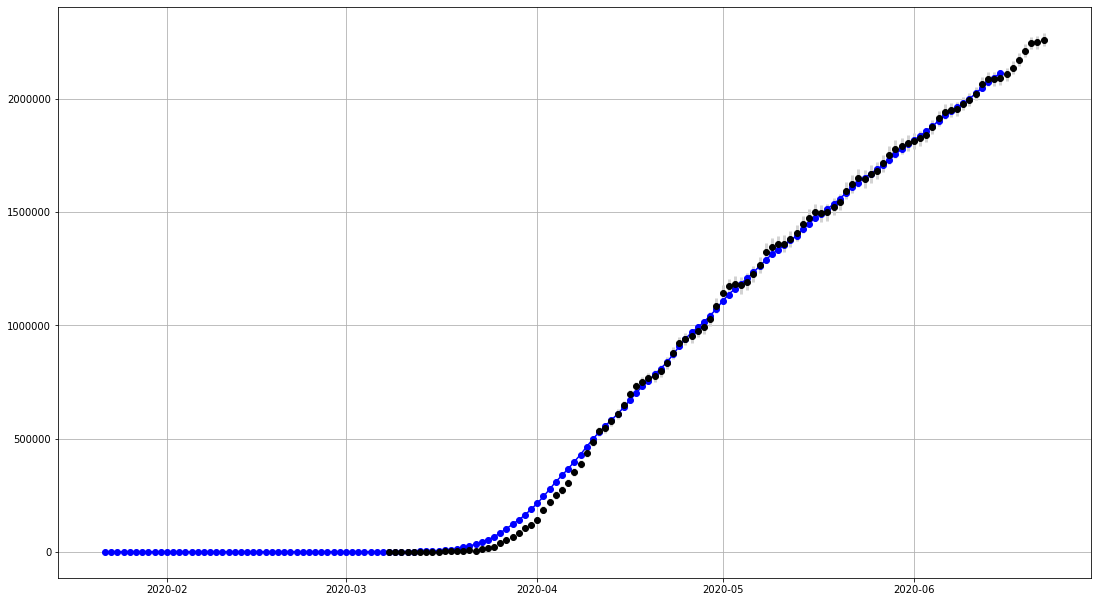

In [14]:
#print(pred_data)

pred_list = [x[3][0] for x in pred_data]
pred_time = [ x[0] for x in pred_data]


y_error_up = [x[3][1] for x in pred_data]
y_error_down = [x[3][2] for x in pred_data]
pred_error = np.array([y_error_down,y_error_up])

print(pred_list)
print(pred_error)

#plt.plot(pred_time, pred_list, 'r', marker="x")

plt.errorbar(pred_time, pred_list, pred_error, fmt='o', color='black', ecolor='lightgray', elinewidth=3, capsize=0)


idx_c = (confirmed['Country/Region']==country_name)
subset_data = confirmed[idx_c]
subset_province_null_idx = subset_data['Province/State'].isnull()
#print(confirmed[idx_c])
print(subset_data[subset_province_null_idx])

print("KURICNA")
target_array = subset_data[subset_province_null_idx][colnames[4:]].values
target_list = list(target_array[0][:])

plt.plot(date_generated, target_list, 'b', marker="o")
plt.grid(True, which="both")
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)


In [15]:
plt.semilogy(target_time, target_value, 'b', marker="o")
plt.semilogy(pred_time, pred_list, 'r', marker="x")
plt.grid(True, which="both")
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

NameError: name 'target_time' is not defined

In [120]:
alpha = 0.7
delta_series = [5,0,-3,1,1,1,1,1]
weights = [alpha*(1-alpha)**i for i,val in enumerate(delta_series)]
print((weights))
delta = [val*alpha*((1-alpha)**i)/(sum(weights)) for i,val in enumerate(delta_series)]
print(delta)
print(sum(delta))

[0.7, 0.21000000000000002, 0.06300000000000001, 0.018900000000000007, 0.005670000000000003, 0.0017010000000000011, 0.0005103000000000004, 0.00015309000000000015]
[3.5002296500673413, 0.0, -0.18901240110363646, 0.018901240110363652, 0.005670372033109096, 0.001701111609932729, 0.0005103334829798188, 0.00015310004489394567]
3.3381534062449836
